# The effect of bin size on compression in tanh
It is mathematically shown that mapping a signal through an injective function does not alter the information content of the signal [Reference due, ask Turan]. Anyhow, with current settings for the binning mutual information estimator we see a reduction in entropy of the resulting signal after mapping through tanh (See https://deep-bottleneck.readthedocs.io/en/latest/experiments/2.minimal_model.html) We attempt to investigate whether this problem in the measurement of mutual information is the root cause for seeing a compression phase in tanh activated networks. We again use the setting of the minimal model with only one neuron and a tanh activation function. We systematiacally vary the number of bins and observe preactivation value ranges for which the mutual information stays constant.


In [1]:
import numpy as np
np.random.seed(0)
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

We sample weights. For every one of these weights we will pass the whole set of input data through the neuron. 

In [2]:
weights = np.arange(0.01, 5, 0.05)

In [3]:
weights

array([ 0.01,  0.06,  0.11,  0.16,  0.21,  0.26,  0.31,  0.36,  0.41,
        0.46,  0.51,  0.56,  0.61,  0.66,  0.71,  0.76,  0.81,  0.86,
        0.91,  0.96,  1.01,  1.06,  1.11,  1.16,  1.21,  1.26,  1.31,
        1.36,  1.41,  1.46,  1.51,  1.56,  1.61,  1.66,  1.71,  1.76,
        1.81,  1.86,  1.91,  1.96,  2.01,  2.06,  2.11,  2.16,  2.21,
        2.26,  2.31,  2.36,  2.41,  2.46,  2.51,  2.56,  2.61,  2.66,
        2.71,  2.76,  2.81,  2.86,  2.91,  2.96,  3.01,  3.06,  3.11,
        3.16,  3.21,  3.26,  3.31,  3.36,  3.41,  3.46,  3.51,  3.56,
        3.61,  3.66,  3.71,  3.76,  3.81,  3.86,  3.91,  3.96,  4.01,
        4.06,  4.11,  4.16,  4.21,  4.26,  4.31,  4.36,  4.41,  4.46,
        4.51,  4.56,  4.61,  4.66,  4.71,  4.76,  4.81,  4.86,  4.91,  4.96])

The input is sampled from a standard normal distribution.

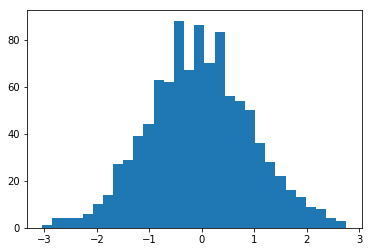

Minimum input: -3.0461430547999266, Maximum input: 2.759355114021582


In [4]:
input_distribution = stats.norm()
input_ = input_distribution.rvs(1000)
plt.hist(input_, bins=30);
plt.show()
print(f'Minimum input: {np.min(input_)}, Maximum input: {np.max(input_)}')

The input is multiplied by the different weights. This is the pass from the input neuron to the hidden neuron. We furthermore calculate the mininmum and maximum preactivation values for each weight as well as their range.

In [5]:
net_input = np.outer(weights, input_)
min_per_weight = np.min(net_input, axis=1)
max_per_weight = np.max(net_input, axis=1)
ranges = max_per_weight - min_per_weight
print(ranges)

[  0.05805498   0.34832989   0.6386048    0.92887971   1.21915462
   1.50942952   1.79970443   2.08997934   2.38025425   2.67052916
   2.96080407   3.25107897   3.54135388   3.83162879   4.1219037
   4.41217861   4.70245352   4.99272843   5.28300333   5.57327824
   5.86355315   6.15382806   6.44410297   6.73437788   7.02465278
   7.31492769   7.6052026    7.89547751   8.18575242   8.47602733
   8.76630223   9.05657714   9.34685205   9.63712696   9.92740187
  10.21767678  10.50795169  10.79822659  11.0885015   11.37877641
  11.66905132  11.95932623  12.24960114  12.53987604  12.83015095
  13.12042586  13.41070077  13.70097568  13.99125059  14.2815255
  14.5718004   14.86207531  15.15235022  15.44262513  15.73290004
  16.02317495  16.31344985  16.60372476  16.89399967  17.18427458
  17.47454949  17.7648244   18.05509931  18.34537421  18.63564912
  18.92592403  19.21619894  19.50647385  19.79674876  20.08702366
  20.37729857  20.66757348  20.95784839  21.2481233   21.53839821
  21.8286731

The activation functions we want to test.

In [6]:
#def hard_sigmoid(x):
#    lower_bound = -2.5
#    upper_bound = 2.5
#    linear = 0.2 * x + 0.5
#    linear[x < lower_bound] = 0
#    linear[x > upper_bound] = 1
#    return linear

def linear(x):
    return x

#activation_functions = [tf.nn.sigmoid, tf.nn.tanh, tf.nn.relu, tf.nn.softsign, tf.nn.softplus, hard_sigmoid, 
#                       tf.nn.selu, tf.nn.relu6, tf.nn.elu, tf.nn.leaky_relu, linear]

activation_functions = [tf.nn.tanh, linear]

Apply the activation functions to the weighted inputs.

In [7]:
outputs = {}
for actvation_function in activation_functions:
    try:
        outputs[actvation_function.__name__] = actvation_function(net_input).numpy()
    except AttributeError:
        outputs[actvation_function.__name__] = actvation_function(net_input)

We now estimate the discrete mututal information between the input $X$ and the activity of the hidden neuron $Y$, which is in this case also the output. $H(Y|X) = 0$, since $Y$ is a deterministic function of $X$. Therefore

\begin{align}
I(X;Y) &= H(Y) - H(Y|X)\\
       &= H(Y)\\
\end{align}

The entropy of the input is 

In [8]:
dig, _ = np.histogram(input_, 1000)
print(f'{stats.entropy(dig, base=2):.2f} bits')

8.80 bits


We create a fixed number of bins between the **minimum and the maximum activity for each weight**.

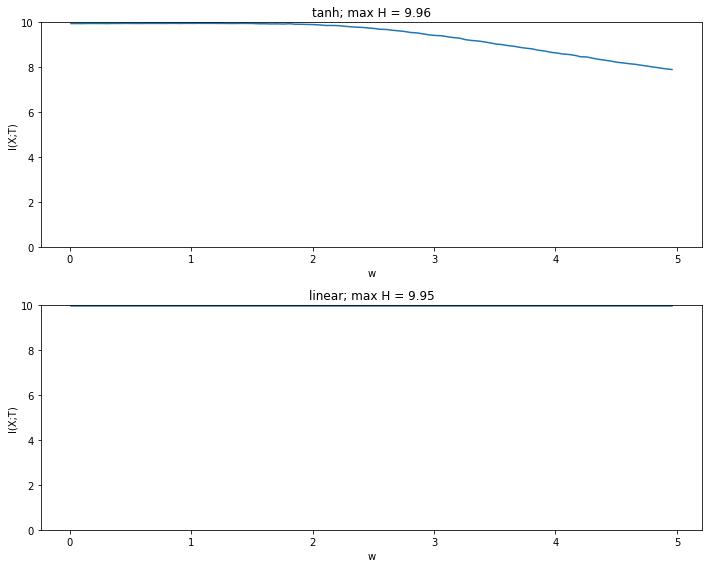

In [9]:
fig, ax = plt.subplots(nrows=len(outputs), figsize=(10, 8), sharey=True)
ax = ax.flat
for ax_idx, (activation_function, Y) in enumerate(outputs.items()):
    
    mi = np.zeros(len(weights))
    for i in range(len(weights)):
        digitized, _ = np.histogram(Y[i], bins=100000)
        mi[i] = stats.entropy(digitized, base=2) 

    ax[ax_idx].plot(weights,  mi)
    ax[ax_idx].set(title=f'{activation_function}; max H = {mi.max():.2f}', xlabel='w', ylabel='I(X;T)', ylim=[0,10]) 
    
plt.tight_layout()
plt.show()

We now systematically vary the amount of bins and match the preactivation value range which yields no more than 5% underestimation of theoretically true MI. 

In [11]:
varying_bins = [1000, 2000, 3000, 4000, 5000, 
                10000, 15000, 20000, 30000, 40000, 50000, 
                100000, 1000000]

#input_entropies
for bins in varying_bins:
    # entropy input
    dig, _ = np.histogram(input_, bins)
    input_entropy = stats.entropy(dig, base=2)
    # entropy representation
    mi = np.zeros(len(weights))
    for i in range(len(weights)):
        digitized, _ = np.histogram(outputs['tanh'][i], bins=bins)
        mi[i] = stats.entropy(digitized, base=2) 
      
    error_threshold = input_entropy * 0.95
    _, indices = np.where([mi < error_threshold])
    first_index_below_threshold = indices[0]
    print(max_per_weight[first_index_below_threshold])

5.40833602348
5.40833602348
5.54630377918
5.82223929059
5.96020704629
6.37411031339
6.65004582479
6.92598133619
7.2019168476
7.477852359
7.6158201147
8.1676911375
10.237207473
